<a href="https://colab.research.google.com/github/kodikarthik21/CS6910---Fundamentals-of-Deep-Learning/blob/main/Assignment03/seq2seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLING REQUIRED DEPENDENCIES AND IMPORTING DATASET

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/lexicons.zip'

Archive:  /content/drive/MyDrive/lexicons.zip
   creating: lexicons/
  inflating: lexicons/ta.translit.sampled.test.tsv  
  inflating: lexicons/ta.translit.sampled.dev.tsv  
  inflating: lexicons/ta.translit.sampled.train.tsv  


In [3]:
!pip install wandb

     |████████████████████████████████| 1.8MB 4.1MB/s 
     |████████████████████████████████| 174kB 40.6MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 133kB 34.2MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=e76ea905c6580755b9f2257e339367fadc142f414a7275907ca14dfe67e02fdc
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=e204880b2190c5eda71d5fa0be6623a600fe49f6cd8ed022981e1e9be8639f41
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# IMPORTING LIBRARIES

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from wandb.keras import WandbCallback
from tensorflow.keras import Input, layers, models
from math import log

# ATTENTION CLASS

In [6]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
    This code is taken from the below link
    https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# DATASET PREPROCESSING

In [7]:
train_df = pd.read_csv("/content/lexicons/ta.translit.sampled.train.tsv", sep = '\t', header = None)
train_df = train_df.dropna(axis=0)

val_df = pd.read_csv("/content/lexicons/ta.translit.sampled.dev.tsv", sep = '\t', header = None)
val_df = val_df.dropna(axis=0)


test_df = pd.read_csv("/content/lexicons/ta.translit.sampled.test.tsv", sep = '\t', header = None)
test_df = test_df.dropna(axis=0)

In [8]:
train_df

,0,1,2
0,ஃபியட்,fiat,2
1,ஃபியட்,phiyat,1
2,ஃபியட்,piyat,1
3,ஃபிரான்ஸ்,firaans,1
4,ஃபிரான்ஸ்,france,2
...,...,...,...
68213,ஹோல்ட்,holtt,1
68214,ஹோல்ட்,hoold,1
68215,ஹோல்ட்,hoolt,1
68216,ஹோல்ட்,hooltt,1


In [9]:
val_df

,0,1,2
0,ஃபயர்,fire,3
1,ஃபயர்,phayar,1
2,ஃபார்,baar,1
3,ஃபார்,bar,1
4,ஃபார்,far,1
...,...,...,...
6822,ஹோலி,hoolley,1
6823,ஹோலி,hoolli,2
6824,ஹோலி,hoolly,1
6825,ஹோலி,hooly,2


In [10]:
test_df

,0,1,2
0,ஃபார்ம்,faarm,1
1,ஃபார்ம்,farm,2
2,ஃபார்ம்,form,1
3,ஃபார்ம்,hpaarm,1
4,ஃபேஸ்,face,3
...,...,...,...
6859,ஹைட்ரோ,haidroa,2
6860,ஹைட்ரோ,haitrao,1
6861,ஹைட்ரோ,hydro,3
6862,ஹைதர்,haithar,2


In [11]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for input_text,target_text in zip(train_df[1][0:],train_df[0][0:]):
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
pred_target_token_index = dict([(i, char) for i, char in enumerate(target_characters)])

if ' ' not in input_token_index:
  input_token_index[' '] = len(input_token_index)

if ' ' not in target_token_index:
  target_token_index[' '] = len(target_token_index)

pred_target_token_index[len(pred_target_token_index)] = ' '
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

num_encoder_tokens = len(input_characters) + 1
num_decoder_tokens = len(target_characters) + 1
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[char]
    encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :] = target_token_index[" "]
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 68215
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28


In [13]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 48,
 'ஃ': 2,
 'அ': 3,
 'ஆ': 4,
 'இ': 5,
 'ஈ': 6,
 'உ': 7,
 'ஊ': 8,
 'எ': 9,
 'ஏ': 10,
 'ஐ': 11,
 'ஒ': 12,
 'ஓ': 13,
 'க': 14,
 'ங': 15,
 'ச': 16,
 'ஜ': 17,
 'ஞ': 18,
 'ட': 19,
 'ண': 20,
 'த': 21,
 'ந': 22,
 'ன': 23,
 'ப': 24,
 'ம': 25,
 'ய': 26,
 'ர': 27,
 'ற': 28,
 'ல': 29,
 'ள': 30,
 'ழ': 31,
 'வ': 32,
 'ஷ': 33,
 'ஸ': 34,
 'ஹ': 35,
 'ா': 36,
 'ி': 37,
 'ீ': 38,
 'ு': 39,
 'ூ': 40,
 'ெ': 41,
 'ே': 42,
 'ை': 43,
 'ொ': 44,
 'ோ': 45,
 'ௌ': 46,
 '்': 47}

In [14]:
# Vectorize the data.
val_input_texts = []
val_target_texts = []

for val_input_text,val_target_text in zip(val_df[1][0:],val_df[0][0:]):
    val_target_text = "\t" + val_target_text + "\n"
    val_input_texts.append(val_input_text)
    val_target_texts.append(val_target_text)

val_encoder_input_data = np.zeros(
    (len(val_input_texts), max_encoder_seq_length), dtype="float32"
)
val_decoder_input_data = np.zeros(
    (len(val_input_texts), max_decoder_seq_length), dtype="float32"
)
val_decoder_target_data = np.zeros(
    (len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t] = input_token_index[char]
    val_encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :] = target_token_index[" "]
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [15]:
# Vectorize the data.
test_input_texts = []
test_target_texts = []

for test_input_text,test_target_text in zip(test_df[1][0:],test_df[0][0:]):
    test_target_text = "\t" + test_target_text + "\n"
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text)

test_encoder_input_data = np.zeros(
    (len(test_input_texts), max_encoder_seq_length), dtype="float32"
)
test_decoder_input_data = np.zeros(
    (len(test_input_texts), max_decoder_seq_length), dtype="float32"
)
test_decoder_target_data = np.zeros(
    (len(test_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(input_text):
        test_encoder_input_data[i, t] = input_token_index[char]
    test_encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    test_decoder_input_data[i, t + 1 :] = target_token_index[" "]
    test_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

# TRAINING THE MODEL

## Building the model

In [16]:
def rnnmodel(cell_name, embedding_size, hidden_size, num_enc_layers, num_dec_layers, dropout, r_dropout, batch_size, num_epochs, optimizer):
  
  cell_type = { "RNN": keras.layers.SimpleRNN,
                "GRU": keras.layers.GRU,
                "LSTM": keras.layers.LSTM
  }

  learning_rate = 0.01
  decay_rate = 0

  optimizers = {"adam": tf.keras.optimizers.Adam(lr=learning_rate, decay=decay_rate),
                "nadam": tf.keras.optimizers.Nadam(lr=learning_rate, decay=decay_rate),
                "rmsprop": tf.keras.optimizers.RMSprop(lr=learning_rate, decay=decay_rate),
                "adagrad": tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
  }

  # Define an input sequence and process it.
  encoder_inputs = keras.layers.Input(shape=(None,), name="input_1")
  embedding = keras.layers.Embedding(num_encoder_tokens, embedding_size, name="embedding_1")(encoder_inputs)
  encoder_seq, *encoder_state = cell_type[cell_name](hidden_size, return_sequences=True,return_state = True, name="encoder_1") (embedding)
  for i in range(1, num_enc_layers):
    encoder_seq, *encoder_state = cell_type[cell_name](hidden_size, return_sequences=True,return_state = True, name="encoder_"+str(i+1), dropout=dropout,
                                                       recurrent_dropout=r_dropout)(encoder_seq)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = keras.Input(shape=(None,), name="input_2")
  decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size, name="embedding_2")(decoder_inputs)

  # We set up our decoder to return full output sequences,
  # and to return internal states as well. We don't use the
  # return states in the training model, but we will use them in inference.
  decoder_seq, *_ = cell_type[cell_name](hidden_size,return_sequences=True, return_state=True, name="decoder_1")(decoder_embedding,initial_state=encoder_state)
  for i in range(1, num_dec_layers):
    decoder_seq, *_ = cell_type[cell_name](hidden_size, return_sequences=True, return_state=True, name="decoder_"+str(i+1),dropout=dropout,
                                      recurrent_dropout=r_dropout)(decoder_seq,initial_state=encoder_state)

  # Attention layer
  # attention_layer = AttentionLayer(name='attention_layer')
  # attention_out, attention_states = attention_layer([decoder_seq,encoder_seq])
  attention_out,attention_states= AttentionLayer(name = 'attention_1')([encoder_seq, decoder_seq])
  # print(attention_out.shape)
  
  #attention_out, attention_states = attention_layer({"values": encoder_seq,"query": decoder_seq}

  # Concatenating the decoder output with attention output
  rnn_output = layers.concatenate([decoder_seq, attention_out], name="rnn_output")

  decoder_outputs = keras.layers.TimeDistributed(keras.layers.Dense(num_decoder_tokens, activation="softmax"),name = 'time_distributed')(rnn_output)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(
    optimizer=optimizers[optimizer], loss="categorical_crossentropy", metrics=["accuracy"]
  )
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=([val_encoder_input_data, val_decoder_input_data],
                      val_decoder_target_data),
       callbacks=[WandbCallback()]
  )

  return model

## Helper function to calculate val accuracy

In [17]:
def word_level_acc(model):
  val_results = model.predict([val_encoder_input_data,val_decoder_input_data])
  val_pred = {}
  for i in range(val_results.shape[0]):
    for j in range(max_decoder_seq_length):
      if(j==0):
        val_pred[i] = pred_target_token_index[np.argmax(val_results[i],axis = 1)[j]]
      else:
        val_pred[i] = val_pred[i] + pred_target_token_index[np.argmax(val_results[i],axis = 1)[j]]
      #print(pred_target_token_index[np.argmax(val_results[i],axis = 1)[j]])
    val_pred[i] = val_pred[i].replace('\n', '')
    val_pred[i] = val_pred[i].replace(' ', '')

  val_print= {}
  count =0;
  for i in range(val_results.shape[0]):
    val_print[i] = [val_df[0][i],val_df[1][i],val_df[2][i],val_pred[i]]
    if(val_df[0][i]==val_pred[i]):
      count = count+1
      print(val_print[i])
  val_acc = count/val_results.shape[0]
  return val_acc

## Training the model

In [18]:
def swp():
  
  hyperparameter_defaults = dict(
      cell_name = "LSTM",
      embedding_size = 32,
      hidden_size = 128,
      num_enc_layers = 2,
      num_dec_layers = 3,
      dropout = 0.5,
      r_dropout = 0,
      batch_size = 256,
      num_epochs = 25,
      optimizer = "adam"
  )

  wandb.init(project="Assignment 3 with Attention", config=hyperparameter_defaults)
  config = wandb.config
  wandb.run.name = "{}_cell_{}_embSize_{}_hiddenSize_{}_encLayers_{}_decLayers_{}_dropout_{}_rDropout_{}_batchSize_{}_epochs_{}_Attention".format(config.cell_name, 
                    config.embedding_size,config.hidden_size, config.num_enc_layers, config.num_dec_layers, config.dropout, config.r_dropout, config.batch_size, config.num_epochs, 
                    config.optimizer)
  
  enc_dec_model = rnnmodel(config.cell_name, config.embedding_size,config.hidden_size, config.num_enc_layers, config.num_dec_layers, config.dropout, config.r_dropout, config.batch_size, 
         config.num_epochs, config.optimizer)
  

  true_val_acc = word_level_acc(enc_dec_model)
  wandb.log({'word_level_val_accuracy':  true_val_acc})
  
  wandb.run.finish()

In [19]:
#swp()

# INFERENCE

In [20]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    i=0;
    attention_scores = np.zeros([max_decoder_seq_length,max_encoder_seq_length])
    while not stop_condition:
        att_s, deco_op, *dec_states = decoder_model.predict([[input_seq], [target_seq] + states_value])
        #print(deco_op)
        # Sample a token
        sampled_token_index = np.argmax(deco_op)
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or sampled_char == " " or len(decoded_sentence) > max_decoder_seq_length:
          stop_condition = True
        else:
          attention_scores[i] = att_s;
          i= i+1;

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = dec_states
        decoded_sentence = decoded_sentence.strip('\n')
        
    target_seq_len = i;
    return decoded_sentence,attention_scores,target_seq_len

In [21]:
def calc_test_acc(model,config):
  # Define sampling models
  # Restore the model and construct the encoder and decoder.
  latent_dim = config['hidden_size']
  encoder_inputs = model.input[0]  # input_1
  encoder_seq,*encoder_states  = model.get_layer('encoder_{}'.format(config['num_enc_layers'])).output
  #encoder_seq,state_h_enc, state_c_enc = encoder_lstm2(encoder_seq)  # lstm_
  encoder_model = keras.Model(encoder_inputs, encoder_states)


  decoder_inputs = keras.layers.Input(shape=(1,), name="input_2") # input_2
  decoder_embed = model.get_layer('embedding_2')
  decoder_input = decoder_embed(decoder_inputs)

  if(config['cell_name'] == 'LSTM'):
    decoder_state_input_h = keras.layers.Input(shape=(latent_dim,), name="input_3")
    decoder_state_input_c = keras.layers.Input(shape=(latent_dim,), name="input_4")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  else:
    decoder_states_inputs = keras.layers.Input(shape=(latent_dim,), name="input_3")

  decoder_lstm1 = model.get_layer('decoder_1')
  decoder_outputs, *decoder_states = decoder_lstm1(
      decoder_input, initial_state=decoder_states_inputs
  )

  for i in range(config['num_dec_layers']-1):
    decoder_outputs, *decoder_states = model.get_layer('decoder_'+str(i+2))(
        decoder_outputs,initial_state=decoder_states_inputs
    )
  
  decoder_attention = model.get_layer('attention_1')
  attention_out,attention_score = decoder_attention([encoder_seq,decoder_outputs])

  decoder_concatenate = model.get_layer('rnn_output')
  rnn_output = decoder_concatenate([decoder_outputs,attention_out])

  decoder_dense = model.get_layer('time_distributed')
  decoder_outputs = decoder_dense(rnn_output)
  
  decoder_model = keras.Model(
    [[encoder_inputs], [decoder_inputs] + decoder_states_inputs], [attention_score, decoder_outputs] + decoder_states
  )

  f = open("predictions_attention1.txt", "a")
  g = open("correct_predictions_attention.txt", "a")
  pred = []
  count = 0
  for i in range(test_df.shape[0]):
    decoded_sentence,attention_scores,target_seq_len = decode_sequence(test_encoder_input_data[i:i+1],encoder_model,decoder_model)
    decoded_sentence = decoded_sentence.strip('\n')
    decoded_sentence = decoded_sentence.strip(' ')
    pred.append(decoded_sentence)
    f.write("Input:" + test_df[1][i] + " True output:" + test_df[0][i] + " Predicted output:" + decoded_sentence + '\n')
    print(i,pred[i])
    if(pred[i] == test_df[0][i]):
      count = count +1
      g.write("Input:" + test_df[1][i] + " True output:" + test_df[0][i] + " Predicted output:" + decoded_sentence + '\n')
  f.close()
  g.close()
  true_test_acc = count/test_df.shape[0]

  return true_test_acc

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     864         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_1 (LSTM)                [(None, None, 128),  82432       embedding_1[0][0]                
______________________________________________________________________________________________

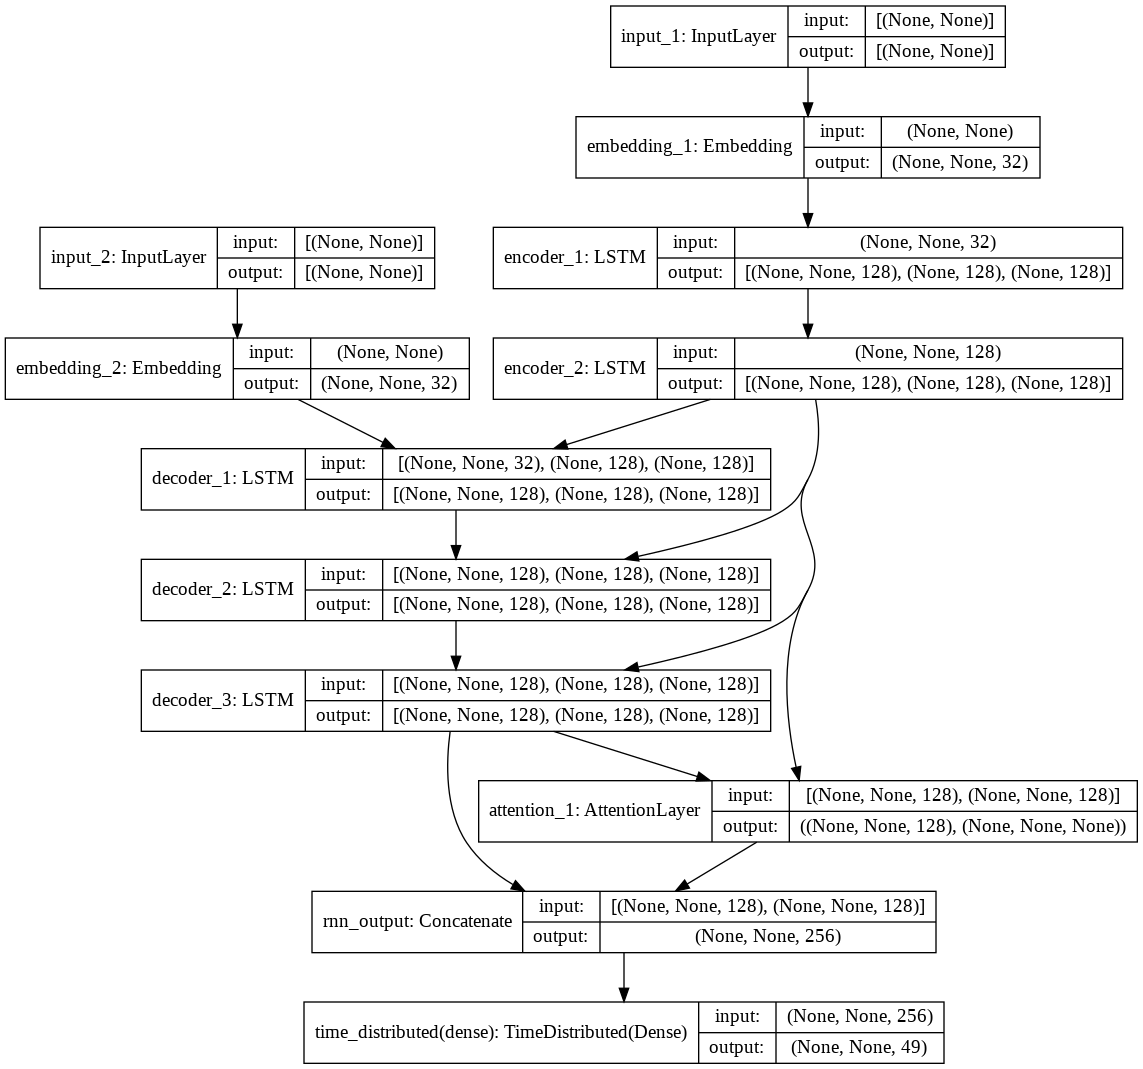

In [22]:
from keras.utils.vis_utils import plot_model

model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 3 with Attention/39y3wgui").name,custom_objects= {'AttentionLayer':AttentionLayer})
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 3 with Attention/39y3wgui").name,custom_objects= {'AttentionLayer':AttentionLayer})
api = wandb.Api()
run = api.run("kodikarthik21/Assignment 3 with Attention/39y3wgui")

config = run.config

#TEST SET - WORD LEVEL ACCURACY

In [ ]:
wandb.init(project="Assignment 3 with Attention", config=run.config)
wandb.run.name = "Test accuracy for best model"
test_acc = calc_test_acc(model,config)
wandb.log({'word_level_test_accuracy':test_acc})
print(test_acc)

# ATTENTION HEATMAP

## Attention scores for samples

In [25]:
def calc_attention_scores(model,config):

  latent_dim = config['hidden_size']
  encoder_inputs = model.input[0]  # input_1
  encoder_seq,*encoder_states  = model.get_layer('encoder_{}'.format(config['num_enc_layers'])).output
  #encoder_seq,state_h_enc, state_c_enc = encoder_lstm2(encoder_seq)  # lstm_
  encoder_model = keras.Model(encoder_inputs, encoder_states)


  decoder_inputs = keras.layers.Input(shape=(1,), name="input_2") # input_2
  decoder_embed = model.get_layer('embedding_2')
  decoder_input = decoder_embed(decoder_inputs)

  if(config['cell_name'] == 'LSTM'):
    decoder_state_input_h = keras.layers.Input(shape=(latent_dim,), name="input_3")
    decoder_state_input_c = keras.layers.Input(shape=(latent_dim,), name="input_4")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  else:
    decoder_states_inputs = keras.layers.Input(shape=(latent_dim,), name="input_3")

  decoder_lstm1 = model.get_layer('decoder_1')
  decoder_outputs, *decoder_states = decoder_lstm1(
      decoder_input, initial_state=decoder_states_inputs
  )

  for i in range(config['num_dec_layers']-1):
    decoder_outputs, *decoder_states = model.get_layer('decoder_'+str(i+2))(
        decoder_outputs,initial_state=decoder_states_inputs
    )
  
  decoder_attention = model.get_layer('attention_1')
  attention_out,attention_score = decoder_attention([encoder_seq,decoder_outputs])

  decoder_concatenate = model.get_layer('rnn_output')
  rnn_output = decoder_concatenate([decoder_outputs,attention_out])

  decoder_dense = model.get_layer('time_distributed')
  decoder_outputs = decoder_dense(rnn_output)
  
  decoder_model = keras.Model(
    [[encoder_inputs], [decoder_inputs] + decoder_states_inputs], [attention_score, decoder_outputs] + decoder_states
  )

  pred = []
  att = []
  count = 0
  for i in range(10):
    decoded_sentence,attention_scores,target_seq_len = decode_sequence(test_encoder_input_data[i:i+1],encoder_model,decoder_model)
    decoded_sentence = decoded_sentence.strip('\n')
    decoded_sentence = decoded_sentence.strip(' ')
    pred.append(decoded_sentence)
    att.append(attention_scores)

  return pred, att


In [26]:
decoded_sentence, att = calc_attention_scores(model,config)

## Plot Attention Heatmap

findfont: Font family ['tamil'] not found. Falling back to DejaVu Sans.


Input: faarm, Pred: பார், Output: ஃபார்ம்


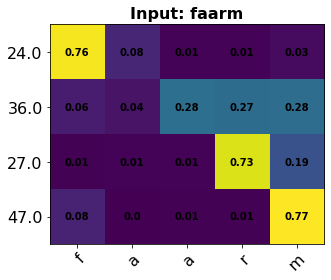

_runtime,3
_timestamp,1621523147
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: farm, Pred: பார், Output: ஃபார்ம்


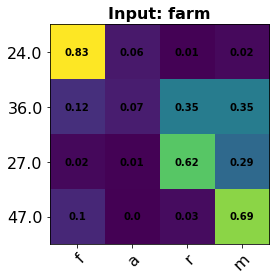

_runtime,3
_timestamp,1621523154
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: form, Pred: போர், Output: ஃபார்ம்


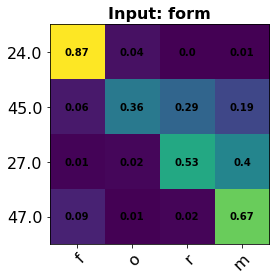

_runtime,3
_timestamp,1621523160
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: hpaarm, Pred: பார்ம், Output: ஃபார்ம்


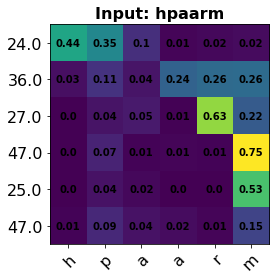

_runtime,3
_timestamp,1621523166
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: face, Pred: பேக், Output: ஃபேஸ்


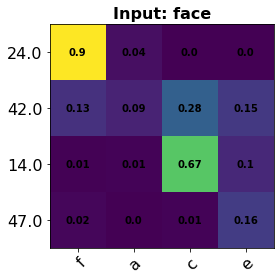

_runtime,3
_timestamp,1621523173
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: hpaes, Pred: ஹேஸ், Output: ஃபேஸ்


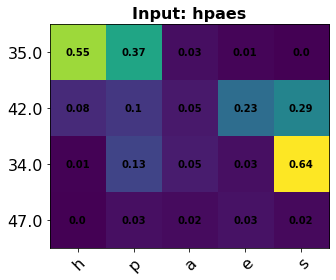

_runtime,4
_timestamp,1621523180
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: pace, Pred: பேச், Output: ஃபேஸ்


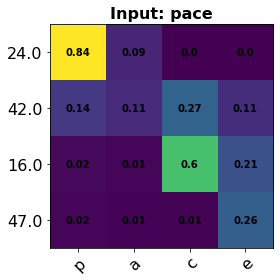

_runtime,3
_timestamp,1621523186
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: paes, Pred: பேஸ், Output: ஃபேஸ்


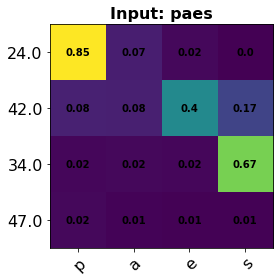

_runtime,3
_timestamp,1621523192
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: phase, Pred: பாச், Output: ஃபேஸ்


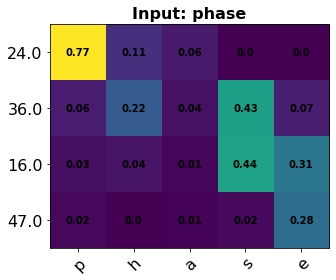

_runtime,3
_timestamp,1621523199
_step,0


_runtime,▁
_timestamp,▁
_step,▁


Input: aeathimuka, Pred: ஏதிமுக, Output: அஇஅதிமுக


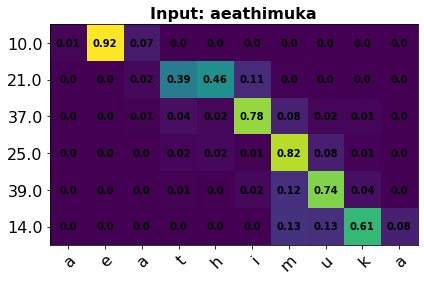

_runtime,3
_timestamp,1621523206
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
# sphinx_gallery_thumbnail_number = 2
for k in range(10):
  wandb.init(project="Assignment 3 with Attention")
  wandb.run.name = "Input: {}, Pred: {}, Output: {}".format(test_df[1][3*k],decoded_sentence[k],test_df[0][k])
  index = np.zeros(len(decoded_sentence[k]))
  for i in range(len(decoded_sentence[k])):
    index[i] = target_token_index[decoded_sentence[k][i]]
  print("Input: {}, Pred: {}, Output: {}".format(test_df[1][k],decoded_sentence[k],test_df[0][k]))
  fig, ax = plt.subplots()
  im = ax.imshow(att[k][0:len(decoded_sentence[k]),0:len(test_df[1][k])])

  # We want to show all ticks...
  ax.set_yticks(np.arange(len(decoded_sentence[k])))
  ax.set_xticks(np.arange(len(test_df[1][k])))
  # ... and label them with the respective list entries
  ax.set_yticklabels(index,size = 16)
  ax.set_xticklabels(test_df[1][k][:])

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor",size = 16)

  # Loop over data dimensions and create text annotations.
  for i in range(len(decoded_sentence[k])):
      for j in range(len(test_df[1][k])):
          text = ax.text(j, i, round(att[k][i, j],2),
                        ha="center", va="center", color="black",weight = 'bold')
  ax.set_title("Input: {}".format(test_df[1][k]), size = 16, weight = 'bold')
  wandb.log({"Input: {}, Pred: {}, Output: {}".format(test_df[1][k],decoded_sentence[k],test_df[0][k]): wandb.Image(plt,caption = "Pred: {}, Output: {}".format(decoded_sentence[k],test_df[0][k]))})
  fig.tight_layout()
  plt.show()
  wandb.run.finish()



#CONNECTIVITY

In [28]:
from IPython.display import HTML as html_print
from IPython.display import display
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

def print_color(char,t):
	display(char,html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

def visualize(output_values, result_list,char):
  #print(output_values)
  #print("\nCell Number:", cell_no, "\n")
  text_colours = []
  for i in range(len(output_values)):
    text = (result_list[i], get_clr(output_values[i]))
    text_colours.append(text)
  print_color(char,text_colours)


In [29]:

for i in range(10):
  for j in range(len(decoded_sentence[i])):
    visualize(att[i][j,0:len(test_df[1][i])],test_df[1][i],decoded_sentence[i][j])

'ப'

'ா'

'ர'

'்'

'ப'

'ா'

'ர'

'்'

'ப'

'ோ'

'ர'

'்'

'ப'

'ா'

'ர'

'்'

'ம'

'்'

'ப'

'ே'

'க'

'்'

'ஹ'

'ே'

'ஸ'

'்'

'ப'

'ே'

'ச'

'்'

'ப'

'ே'

'ஸ'

'்'

'ப'

'ா'

'ச'

'்'

'ஏ'

'த'

'ி'

'ம'

'ு'

'க'